Блок 1
---


- Импорт библиотек и создание Spark-сессии

In [1]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, DateType, DoubleType

# чтобы в Colab / Jupyter PySpark использовал тот же Python
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

spark = (SparkSession.builder
         .appName("COVID-19 CXR metadata monitoring")
         .config("spark.driver.memory", "4g")
         .config("spark.executor.memory", "4g")
         .config("spark.sql.shuffle.partitions", "4")
         .getOrCreate())

print("Spark version:", spark.version)

Spark version: 4.0.1


Блок 2
---

- Загрузка датасета и первичный осмотр


In [2]:
url = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv"
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)
csv_path = os.path.join(data_dir, "metadata.csv")

if not os.path.exists(csv_path):
    import urllib.request
    print("Скачиваю metadata.csv ...")
    urllib.request.urlretrieve(url, csv_path)
    print("Готово:", csv_path)
else:
    print("Файл уже существует:", csv_path)

# читаем только нужные поля
raw_df = (spark.read
          .option("header", True)
          .csv(csv_path))

cols = ["patientid", "age", "sex", "finding", "view", "date"]
meta_df = raw_df.select(*cols)

meta_df.printSchema()
meta_df.show(10, truncate=False)
print("Всего строк:", meta_df.count())

Файл уже существует: data/metadata.csv
root
 |-- patientid: string (nullable = true)
 |-- age: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- finding: string (nullable = true)
 |-- view: string (nullable = true)
 |-- date: string (nullable = true)

+---------+----+----+------------------------+----+----------------+
|patientid|age |sex |finding                 |view|date            |
+---------+----+----+------------------------+----+----------------+
|2        |65  |M   |Pneumonia/Viral/COVID-19|PA  |January 22, 2020|
|2        |65  |M   |Pneumonia/Viral/COVID-19|PA  |January 25, 2020|
|2        |65  |M   |Pneumonia/Viral/COVID-19|PA  |January 27, 2020|
|2        |65  |M   |Pneumonia/Viral/COVID-19|PA  |January 28, 2020|
|4        |52  |F   |Pneumonia/Viral/COVID-19|PA  |January 25, 2020|
|4        |52  |F   |Pneumonia/Viral/COVID-19|PA  |January 30, 2020|
|5        |NULL|NULL|Pneumonia               |PA  |2017            |
|6        |NULL|NULL|Pneumonia/Viral/COVID-

Блок 3
---

- Анализ пропусков и грубых аномалий

      column  nulls  null_rate
5       date    289   0.304211
1        age    237   0.249474
2        sex     80   0.084211
0  patientid      0   0.000000
3    finding      0   0.000000
4       view      0   0.000000


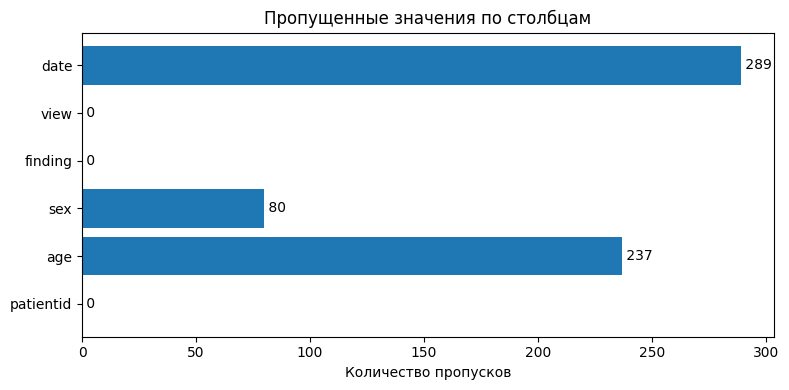

In [3]:
total_rows = meta_df.count()

# считаем, сколько null в каждой колонке
null_info = []
for c in meta_df.columns:
    null_cnt = meta_df.where(F.col(c).isNull()).count()
    null_info.append((c, null_cnt))

null_df = pd.DataFrame(null_info, columns=["column", "nulls"])
null_df["null_rate"] = null_df["nulls"] / total_rows

print(null_df.sort_values("null_rate", ascending=False))

# визуализация пропусков
plt.figure(figsize=(8, 4))
bars = plt.barh(null_df["column"], null_df["nulls"])
plt.xlabel("Количество пропусков")
plt.title("Пропущенные значения по столбцам")

for bar in bars:
    val = bar.get_width()
    plt.text(val, bar.get_y() + bar.get_height()/2,
             f" {int(val)}", va="center", ha="left")

plt.tight_layout()
plt.show()

Анализ возраста (до чистки):

Всего записей с корректным age: 713


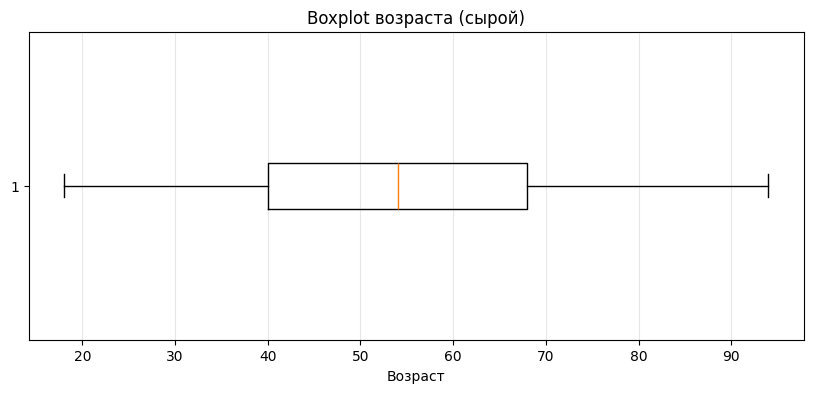

Оценка количества выбросов по возрасту: 0
Пропусков в age (по исходному DataFrame): 237


In [4]:
# переводим возраст в float (через замену запятой на точку)
age_parsed_df = meta_df.withColumn(
    "age_float",
    F.regexp_replace(F.col("age").cast("string"), ",", ".").cast("double")
)

age_pd = (age_parsed_df
          .select("age_float")
          .where(F.col("age_float").isNotNull())
          .toPandas()["age_float"])

print("Всего записей с корректным age:", len(age_pd))

plt.figure(figsize=(10, 4))
plt.boxplot(age_pd.dropna(), vert=False)
plt.xlabel("Возраст")
plt.title("Boxplot возраста (сырой)")
plt.grid(axis="x", alpha=0.3)
plt.show()

q1 = age_pd.quantile(0.25)
q3 = age_pd.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

outliers_count = ((age_pd < lower) | (age_pd > upper) | (age_pd < 0) | (age_pd > 120)).sum()
print("Оценка количества выбросов по возрасту:", int(outliers_count))
print("Пропусков в age (по исходному DataFrame):", meta_df.where(F.col("age").isNull()).count())

Проблемы качества данных см. в конце.

Блок 4
---

- Вспомогательные функции (UDF): дата, возрастные категории, диагноз

In [5]:
def parse_date_smart(txt):
    """
    Пробуем несколько форматов даты.
    Если год не указан явно (типа 'March 12'), подставляем 2020.
    """
    if txt is None:
        return None
    s = str(txt).strip()
    if not s:
        return None

    patterns = [
        "%B %d, %Y",   # January 22, 2020
        "%b %d, %Y",   # Feb 18, 2020
        "%d %B %Y",    # 12 March 2020
        "%d %b %Y",    # 12 Mar 2020
        "%m/%d/%Y",    # 3/3/2020
        "%m/%d/%y",    # 03/16/20
        "%B %Y",       # March 2003
        "%b %Y",       # Mar 2003
        "%Y",          # 2014
        "%B %d",       # January 12
        "%b %d",       # Feb 18
        "%d %B",       # 12 March
        "%d %b",       # 12 Mar
    ]

    for p in patterns:
        try:
            dt = datetime.strptime(s, p).date()
            # если в шаблоне нет года — договоримся ставить 2020
            if p in ["%B %d", "%b %d", "%d %B", "%d %b"]:
                dt = dt.replace(year=2020)
            return dt
        except Exception:
            continue
    return None


def age_band(age_value):
    """
    Простая разбивка возраста на группы.
    """
    try:
        a = float(age_value)
    except (TypeError, ValueError):
        return "Unknown"
    if a < 18:
        return "0-17"
    elif a < 30:
        return "18-29"
    elif a < 45:
        return "30-44"
    elif a < 60:
        return "45-59"
    elif a < 75:
        return "60-74"
    else:
        return "75+"


def normalize_finding(f):
    """
    Укрупнение диагнозов до ограниченного набора категорий.
    """
    if f is None:
        return "Unknown"
    s = str(f).lower().strip()

    # COVID-группа
    if any(word in s for word in ["covid", "sars-cov-2", "coronavirus", "corona"]):
        return "COVID-19"

    # Пневмонии
    if "pneumonia" in s:
        return "Pneumonia"

    # ARDS
    if "ards" in s or "acute respiratory distress" in s:
        return "ARDS"

    # Относительно нормальные случаи
    if any(word in s for word in ["no finding", "normal", "clear"]):
        return "Normal"

    # Туберкулёз выделим отдельно
    if "tuberculosis" in s or "tb" in s:
        return "Tuberculosis"

    # Остальное — либо сокращаем, либо складываем в Other
    if "/" in s:
        return s.split("/")[0].strip().title()
    if len(s) > 30:
        return "Other"
    return s.title()

# Регистрация как UDF
parse_date_udf = F.udf(parse_date_smart, DateType())
age_band_udf = F.udf(age_band, StringType())
normalize_finding_udf = F.udf(normalize_finding, StringType())

Блок 5
---

- Предобработка: заполнение пропусков, нормализация, дубликаты

In [6]:
# 5.1. Возраст: приводим к float и считаем медиану
age_float_col = F.regexp_replace(F.col("age").cast("string"), ",", ".").cast(DoubleType())
meta_df_num = meta_df.withColumn("age_float", age_float_col)

age_median = (meta_df_num
              .where(F.col("age_float").isNotNull())
              .approxQuantile("age_float", [0.5], 0.01)[0])

print("Медиана возраста:", age_median)

meta_df_num = meta_df_num.withColumn(
    "age_clean",
    F.when(F.col("age_float").isNull(), age_median).otherwise(F.col("age_float"))
)

# 5.2. Пол: заменяем пропуски на модальное значение
sex_not_null = (meta_df_num
                .where(F.col("sex").isNotNull() & (F.col("sex") != ""))
                .groupBy("sex")
                .count()
                .orderBy(F.desc("count"))
                .first())

default_sex = sex_not_null["sex"] if sex_not_null else "Unknown"
print("Самое частое значение sex:", default_sex)

meta_df_num = meta_df_num.withColumn(
    "sex_clean",
    F.when(F.col("sex").isNull(), default_sex).otherwise(F.col("sex"))
)

# 5.3. Дата: парсинг + заполнение модой
meta_df_num = meta_df_num.withColumn("date_parsed", parse_date_udf(F.col("date")))

most_common_date_row = (meta_df_num
                        .where(F.col("date_parsed").isNotNull())
                        .groupBy("date_parsed")
                        .count()
                        .orderBy(F.desc("count"))
                        .first())

default_date = most_common_date_row["date_parsed"] if most_common_date_row else None
print("Самая частая дата:", default_date)

meta_df_num = meta_df_num.withColumn(
    "date_clean",
    F.when(F.col("date_parsed").isNotNull(), F.col("date_parsed")).otherwise(default_date)
)

# 5.4. Возрастные категории + унификация диагнозов
meta_df_num = meta_df_num.withColumn("age_group", age_band_udf(F.col("age_clean")))
meta_df_num = meta_df_num.withColumn("finding_unified", normalize_finding_udf(F.col("finding")))

# 5.5. Удаляем полные дубликаты
clean_df = (meta_df_num
            .dropDuplicates(["patientid", "age_clean", "sex_clean", "finding_unified", "view", "date_clean"]))

print("До удаления дублей:", meta_df_num.count())
print("После удаления дублей:", clean_df.count())

# 5.6. Финальный набор колонок для анализа
clean_df = clean_df.select(
    F.col("patientid"),
    F.col("age_clean").alias("age"),
    F.col("sex_clean").alias("sex"),
    F.col("finding_unified").alias("finding"),
    F.col("view"),
    F.col("date_clean").alias("date"),
    F.col("age_group")
)

clean_df.show(10, truncate=False)

Медиана возраста: 54.0
Самое частое значение sex: M
Самая частая дата: 2020-01-01
До удаления дублей: 950
После удаления дублей: 667
+---------+----+---+------------+---------+----------+---------+
|patientid|age |sex|finding     |view     |date      |age_group|
+---------+----+---+------------+---------+----------+---------+
|393      |21.0|F  |Tuberculosis|AP       |2020-01-01|18-29    |
|398      |21.0|F  |Pneumonia   |AP Supine|2020-01-01|18-29    |
|171      |23.0|F  |Pneumonia   |PA       |2003-03-01|18-29    |
|31       |25.0|F  |Pneumonia   |AP       |2014-01-01|18-29    |
|31       |25.0|F  |Pneumonia   |PA       |2014-01-01|18-29    |
|358      |25.0|F  |COVID-19    |L        |2020-01-01|18-29    |
|358      |25.0|F  |COVID-19    |PA       |2020-01-01|18-29    |
|457      |25.0|F  |Tuberculosis|L        |2020-01-01|18-29    |
|457      |25.0|F  |Tuberculosis|PA       |2020-01-01|18-29    |
|469      |25.0|F  |Pneumonia   |L        |2020-01-01|18-29    |
+---------+----+---+--

Блок 6
---

- SQL-аналитика: 5 запросов из задания

In [7]:
clean_df.createOrReplaceTempView("cxr")

# 1) Базовая статистика по диагнозам
q_diag = spark.sql("""
    SELECT
        finding,
        COUNT(*) AS cnt,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER(), 2) AS pct
    FROM cxr
    GROUP BY finding
    ORDER BY cnt DESC
""")
q_diag.show(20, truncate=False)

+------------+---+-----+
|finding     |cnt|pct  |
+------------+---+-----+
|COVID-19    |437|65.52|
|Pneumonia   |165|24.74|
|Todo        |27 |4.05 |
|Normal      |20 |3.00 |
|Tuberculosis|17 |2.55 |
|Unknown     |1  |0.15 |
+------------+---+-----+



In [8]:
# 2) Распределение по полу и диагнозам
q_sex_diag = spark.sql("""
    SELECT
        sex,
        finding,
        COUNT(*) AS cnt,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY sex), 2) AS pct_within_sex
    FROM cxr
    GROUP BY sex, finding
    ORDER BY sex, cnt DESC
""")
q_sex_diag.show(20, truncate=False)

+---+------------+---+--------------+
|sex|finding     |cnt|pct_within_sex|
+---+------------+---+--------------+
|F  |COVID-19    |129|62.02         |
|F  |Pneumonia   |59 |28.37         |
|F  |Normal      |9  |4.33          |
|F  |Todo        |6  |2.88          |
|F  |Tuberculosis|5  |2.40          |
|M  |COVID-19    |308|67.10         |
|M  |Pneumonia   |106|23.09         |
|M  |Todo        |21 |4.58          |
|M  |Tuberculosis|12 |2.61          |
|M  |Normal      |11 |2.40          |
|M  |Unknown     |1  |0.22          |
+---+------------+---+--------------+



In [9]:
# 3) Оконная функция: топ-3 по возрасту в каждой группе диагнозов
q_top3 = spark.sql("""
    SELECT
        finding,
        patientid,
        age,
        sex,
        date,
        rn
    FROM (
        SELECT
            finding,
            patientid,
            age,
            sex,
            date,
            ROW_NUMBER() OVER (PARTITION BY finding ORDER BY age DESC) AS rn
        FROM (
            SELECT DISTINCT patientid, age, sex, finding, date
            FROM cxr
        ) base
    ) t
    WHERE rn <= 3
    ORDER BY finding, rn
""")
q_top3.show(20, truncate=False)

+------------+---------+----+---+----------+---+
|finding     |patientid|age |sex|date      |rn |
+------------+---------+----+---+----------+---+
|COVID-19    |326b     |94.0|M  |2020-01-01|1  |
|COVID-19    |324b     |93.0|F  |2020-01-01|2  |
|COVID-19    |200      |88.0|M  |2020-01-01|3  |
|Normal      |315      |78.0|F  |2020-03-04|1  |
|Normal      |325      |78.0|F  |2020-03-12|2  |
|Normal      |478      |75.0|F  |2020-01-01|3  |
|Pneumonia   |460      |90.0|M  |2020-01-01|1  |
|Pneumonia   |91       |80.0|F  |2018-01-01|2  |
|Pneumonia   |340      |80.0|M  |2013-01-01|3  |
|Todo        |386      |54.0|M  |2020-01-01|1  |
|Todo        |391      |54.0|M  |2020-01-01|2  |
|Todo        |425d     |54.0|M  |2020-01-01|3  |
|Tuberculosis|421      |78.0|M  |2020-01-01|1  |
|Tuberculosis|453      |70.0|M  |2020-01-01|2  |
|Tuberculosis|456      |58.0|M  |2020-01-01|3  |
|Unknown     |221      |54.0|M  |2020-01-01|1  |
+------------+---------+----+---+----------+---+



In [10]:
# 4) Временные тренды по датам исследований
q_trend = spark.sql("""
    SELECT
        YEAR(date)  AS year,
        MONTH(date) AS month,
        COUNT(*)    AS studies,
        COUNT(DISTINCT patientid) AS unique_patients,
        ROUND(AVG(age), 1) AS avg_age
    FROM cxr
    GROUP BY YEAR(date), MONTH(date)
    ORDER BY year, month
""")
q_trend.show(50, truncate=False)

+----+-----+-------+---------------+-------+
|year|month|studies|unique_patients|avg_age|
+----+-----+-------+---------------+-------+
|2003|3    |3      |3              |40.7   |
|2004|1    |5      |5              |52.8   |
|2007|1    |1      |1              |54.0   |
|2009|9    |3      |1              |30.0   |
|2010|1    |3      |2              |54.0   |
|2010|5    |2      |1              |40.0   |
|2010|10   |1      |1              |30.0   |
|2011|1    |3      |2              |46.7   |
|2013|1    |5      |3              |65.6   |
|2014|1    |6      |4              |50.7   |
|2015|1    |11     |8              |56.0   |
|2015|5    |1      |1              |65.0   |
|2016|1    |14     |8              |49.0   |
|2017|1    |3      |2              |40.7   |
|2017|6    |1      |1              |35.0   |
|2018|1    |3      |2              |76.7   |
|2019|1    |2      |1              |61.0   |
|2019|2    |1      |1              |50.0   |
|2019|5    |1      |1              |65.0   |
|2019|11  

In [11]:
# 5) Статистика по проекциям и диагнозам
q_view = spark.sql("""
    SELECT
        view,
        finding,
        COUNT(*) AS cnt,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY view), 2) AS pct_within_view,
        ROUND(AVG(age), 1) AS avg_age
    FROM cxr
    GROUP BY view, finding
    ORDER BY view, cnt DESC
""")
q_view.show(50, truncate=False)

+---------+------------+---+---------------+-------+
|view     |finding     |cnt|pct_within_view|avg_age|
+---------+------------+---+---------------+-------+
|AP       |COVID-19    |106|72.11          |58.2   |
|AP       |Pneumonia   |34 |23.13          |52.6   |
|AP       |Normal      |5  |3.40           |60.6   |
|AP       |Tuberculosis|2  |1.36           |45.5   |
|AP Erect |Pneumonia   |1  |100.00         |30.0   |
|AP Supine|COVID-19    |94 |72.87          |58.2   |
|AP Supine|Todo        |17 |13.18          |54.0   |
|AP Supine|Pneumonia   |15 |11.63          |48.9   |
|AP Supine|Normal      |2  |1.55           |49.5   |
|AP Supine|Unknown     |1  |0.78           |54.0   |
|Axial    |COVID-19    |44 |93.62          |50.2   |
|Axial    |Normal      |3  |6.38           |40.7   |
|Coronal  |COVID-19    |12 |100.00         |48.8   |
|L        |Pneumonia   |39 |55.71          |51.7   |
|L        |COVID-19    |25 |35.71          |53.0   |
|L        |Tuberculosis|6  |8.57           |37

Блок 7
---

- Обработка в PySpark: фильтрация и сохранение в Parquet

In [12]:
filtered_df = clean_df.where(
    (F.col("finding") == "COVID-19") &
    (F.col("age") >= 18)
)

print("Всего записей:", clean_df.count())
print("После фильтрации (COVID-19, возраст >= 18):", filtered_df.count())

out_dir = "parquet_covid_adults"
filtered_df.write.mode("overwrite").parquet(out_dir)

# быстрая проверка, что Parquet читается
spark.read.parquet(out_dir).show(10, truncate=False)

Всего записей: 667
После фильтрации (COVID-19, возраст >= 18): 437
+---------+----+---+--------+---------+----------+---------+
|patientid|age |sex|finding |view     |date      |age_group|
+---------+----+---+--------+---------+----------+---------+
|358      |25.0|F  |COVID-19|L        |2020-01-01|18-29    |
|358      |25.0|F  |COVID-19|PA       |2020-01-01|18-29    |
|69       |25.0|F  |COVID-19|PA       |2020-01-24|18-29    |
|69       |25.0|F  |COVID-19|PA       |2020-01-28|18-29    |
|184      |29.0|F  |COVID-19|L        |2020-01-01|18-29    |
|184      |29.0|F  |COVID-19|PA       |2020-01-01|18-29    |
|144      |30.0|F  |COVID-19|AP Supine|2020-01-01|30-44    |
|174      |30.0|F  |COVID-19|PA       |2020-01-01|30-44    |
|183      |30.0|F  |COVID-19|AP       |2020-01-01|30-44    |
|183      |30.0|F  |COVID-19|PA       |2020-01-01|30-44    |
+---------+----+---+--------+---------+----------+---------+
only showing top 10 rows


Блок 8
---

- Визуализация

In [13]:
pdf = clean_df.toPandas()

***Круговая диаграмма диагнозов***

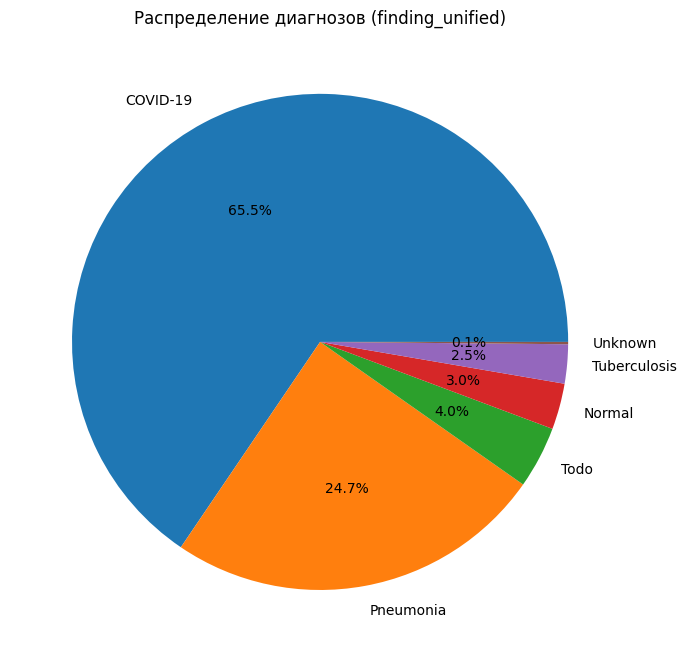

In [14]:
plt.figure(figsize=(7, 7))
pdf["finding"].value_counts().plot(
    kind="pie",
    autopct="%1.1f%%",
    ylabel=""
)
plt.title("Распределение диагнозов (finding_unified)")
plt.tight_layout()
plt.show()

Основной объём выборки занимает COVI (примерно две трети всех записей), на втором месте – Pneumonia. Доли Normal, Tuberculosis и прочих категорий существенно меньше, что говорит о смещённости датасета в сторону инфицированных пациентов.
Сложно будет делать "правильную" статистику из-за этого.

***Столбчатая диаграмма возрастных групп***

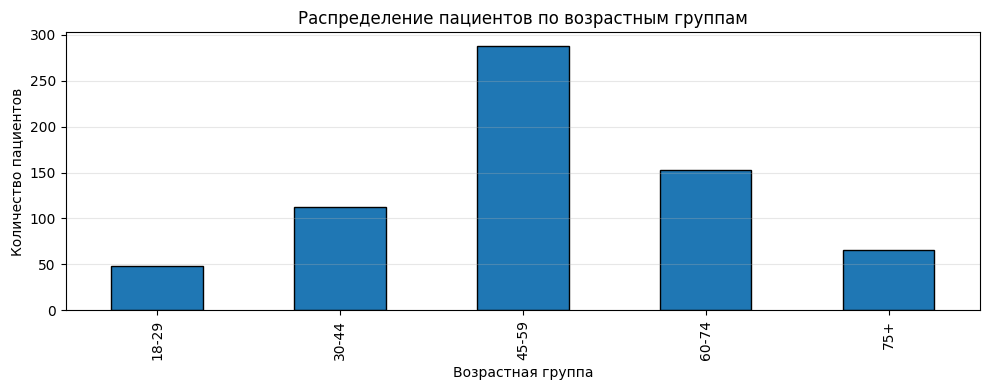

In [15]:
plt.figure(figsize=(10, 4))
age_counts = pdf["age_group"].value_counts().sort_index()
age_counts.plot(kind="bar", edgecolor="black")
plt.title("Распределение пациентов по возрастным группам")
plt.xlabel("Возрастная группа")
plt.ylabel("Количество пациентов")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Наибольшее число пациентов приходится на группы 45–59 и 60–74, то есть средний и пожилой возраст. Младшие группы представлены заметно слабее.

***Временные тренды исследований***

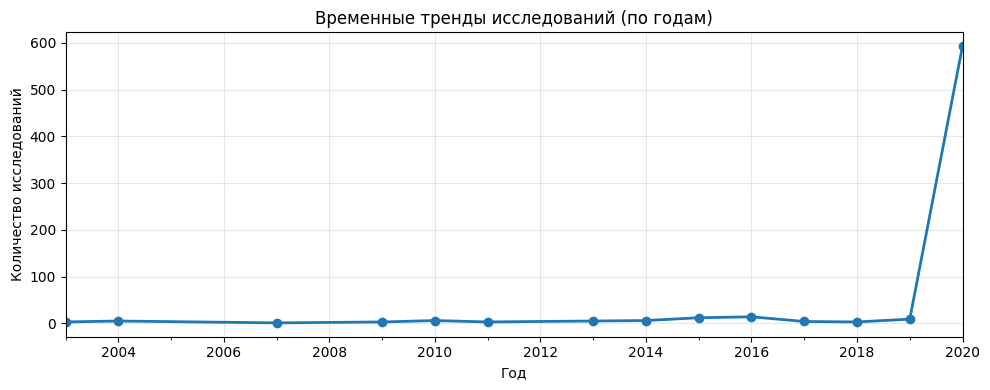

In [16]:
pdf["date"] = pd.to_datetime(pdf["date"])
by_year = pdf.groupby(pdf["date"].dt.to_period("Y")).size()

plt.figure(figsize=(10, 4))
by_year.plot(marker="o", linewidth=2)
plt.title("Временные тренды исследований (по годам)")
plt.xlabel("Год")
plt.ylabel("Количество исследований")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

До 2020 года количество исследований в датасете небольшое и колеблется вокруг низких значений, это скорее “исторический хвост” из разных источников. В 2020 году наблюдается резкий скачок количества снимков – именно в этот период начинается массовое накопление данных, связанное с COVID.

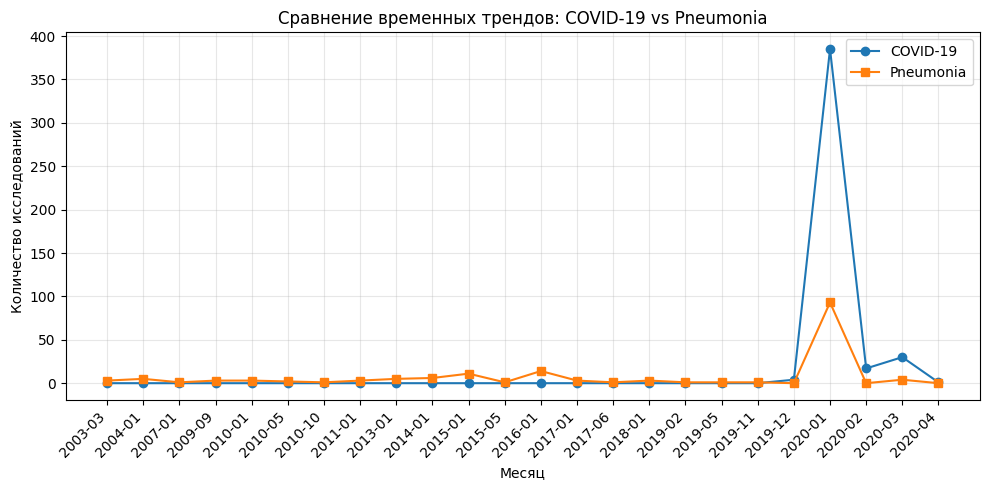

In [17]:
pdf_trend = clean_df.select("finding", "date").toPandas()
pdf_trend["date"] = pd.to_datetime(pdf_trend["date"])

# оставляем только интересующие нас диагнозы
mask = pdf_trend["finding"].isin(["COVID-19", "Pneumonia"])
pdf_trend = pdf_trend[mask].copy()

# группируем по месяцам и диагнозу
pdf_trend["month"] = pdf_trend["date"].dt.to_period("M")

monthly_counts = (pdf_trend
                  .groupby(["month", "finding"])
                  .size()
                  .reset_index(name="count"))

# разворачиваем в таблицу формат wide: столбцы = диагнозы
pivot_trend = monthly_counts.pivot(index="month", columns="finding", values="count").fillna(0)

# чтобы красиво отобразить по оси X
pivot_trend.index = pivot_trend.index.astype(str)

plt.figure(figsize=(10, 5))

if "COVID-19" in pivot_trend.columns:
    plt.plot(pivot_trend.index, pivot_trend["COVID-19"], marker="o", label="COVID-19")
if "Pneumonia" in pivot_trend.columns:
    plt.plot(pivot_trend.index, pivot_trend["Pneumonia"], marker="s", label="Pneumonia")

plt.title("Сравнение временных трендов: COVID-19 vs Pneumonia")
plt.xlabel("Месяц")
plt.ylabel("Количество исследований")
plt.xticks(rotation=45, ha="right")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

В районе 2020-02 видно резкий всплеск обеих кривых: COVID выходит на первый план, а Pneumonia также резко увеличивается, но с меньшей амплитудой. Дальше наблюдается спад, но значения не возвращаются к нулю, что отражает длительную “хвостовую” часть пандемии.

***Heatmap: диагнозы по проекциям снимков***

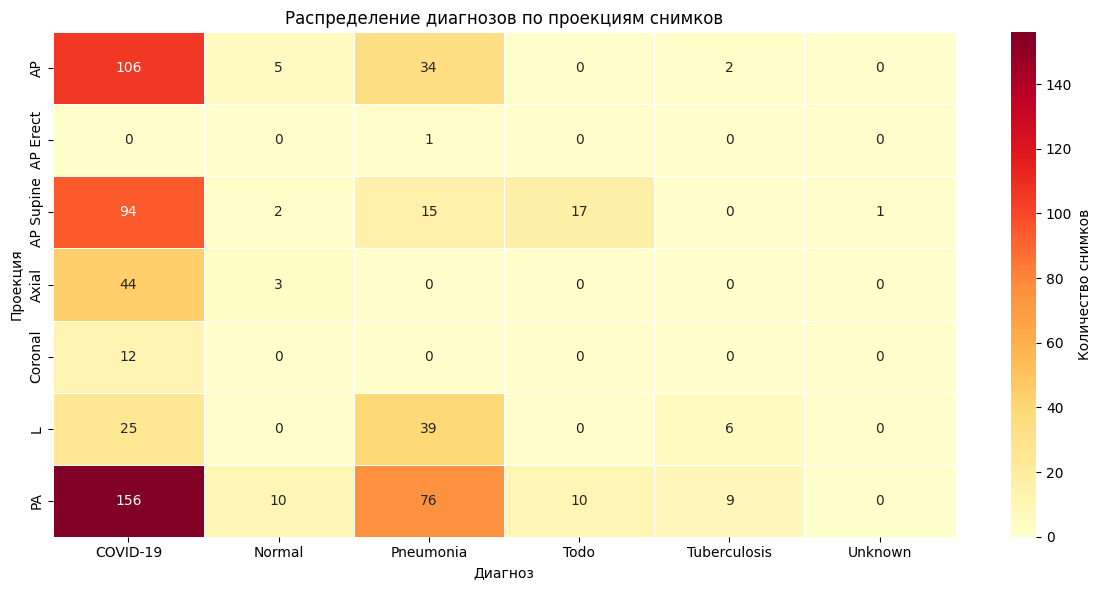

In [18]:
heat_data = (pdf
             .groupby(["view", "finding"])
             .size()
             .unstack(fill_value=0))

# на всякий случай ограничимся топовыми view (если очень много разных)
top_views = pdf["view"].value_counts().head(10).index
heat_data = heat_data.loc[heat_data.index.isin(top_views)]

plt.figure(figsize=(12, 6))
sns.heatmap(
    heat_data,
    annot=True,
    fmt="d",
    cmap="YlOrRd",
    linewidths=0.5,
    cbar_kws={"label": "Количество снимков"}
)
plt.title("Распределение диагнозов по проекциям снимков")
plt.xlabel("Диагноз")
plt.ylabel("Проекция")
plt.tight_layout()
plt.show()

Больше всего снимков сделано в проекциях PA и AP, и именно в них сосредоточены основные случаи COVIВ и Pneumonia. Проекция AP Supine тоже сильно нагружена COVID-19. Редкие проекции (Coronal, Axial и т.п.) используются гораздо реже и дают мало данных для устойчивой статистики.

***распределение диагнозов по полу***

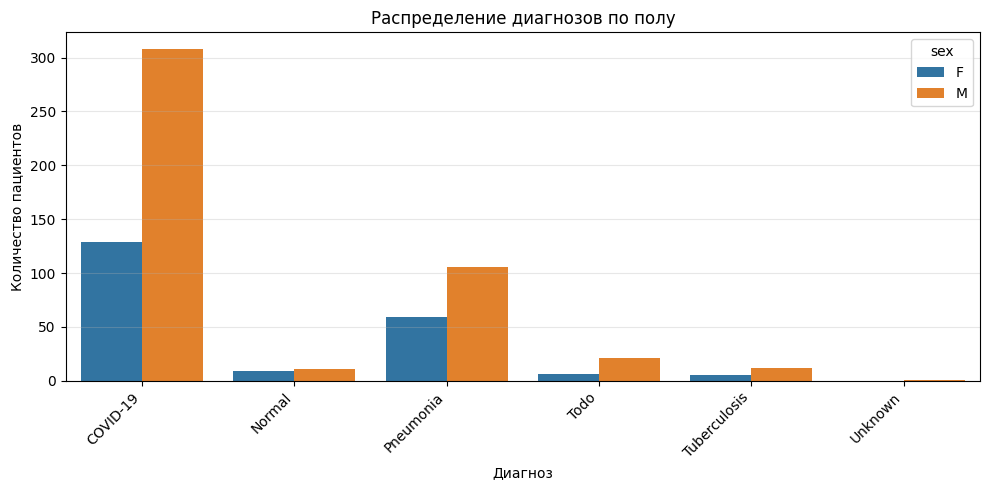

In [19]:
plt.figure(figsize=(10, 5))

sex_finding_counts = (
    pdf
    .groupby(["sex", "finding"])
    .size()
    .reset_index(name="count")
)

sns.barplot(
    data=sex_finding_counts,
    x="finding",
    y="count",
    hue="sex"
)

plt.title("Распределение диагнозов по полу")
plt.xlabel("Диагноз")
plt.ylabel("Количество пациентов")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Количество случаев COVID заметно выше у мужчин, чем у женщин; похожая картина наблюдается и для Pneumonia. Для Normal и других диагнозов различия по полу менее выражены, но общая тенденция – мужчины представлены чаще.

***распределение возраста по диагнозам***

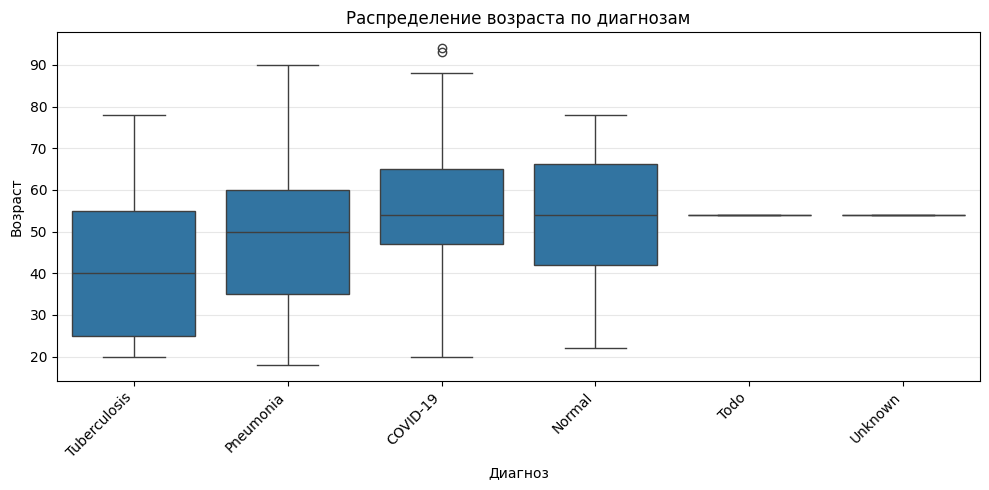

In [20]:
plt.figure(figsize=(10, 5))

# Немного чистим NaN, чтобы не падало
age_diag = pdf[["age", "finding"]].dropna()

sns.boxplot(
    data=age_diag,
    x="finding",
    y="age"
)

plt.title("Распределение возраста по диагнозам")
plt.xlabel("Диагноз")
plt.ylabel("Возраст")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Для Pneumonia и COVID медианный возраст находится примерно в районе 50 лет, с довольно широким разбросом и наличием пожилых пациентов. У Tuberculosis возрастная группа чуть моложе, а Normal распределён более равномерно. В целом данные подтверждают, что тяжёлые респираторные диагнозы чаще встречаются у пациентов среднего и старшего возраста.

Финальные итоги
---

- Датасет сильно смещён в сторону пациентов с COVID и Pneumonia, нормальных случаев относительно мало.

- Основной контингент – пациенты среднего и пожилого возраста, что особенно заметно для тяжёлых диагнозов.

- По полу выборка несимметрична: мужчины чаще представлены среди пациентов с COVID и Pneumonia.

- По проекциям снимков доминируют типы PA и AP, в них сосредоточена основная нагрузка по COVID

- Временные ряды показывают резкий скачок исследований в 2020 году и выраженный пик для COVID и Pneumonia.

- Главные проблемы данных: неполнота и несбалансированность выборки (перекос в сторону COVID, мало нормальных и редких диагнозов, неоднородное распределение по возрасту и полу).

***Проблемы качества данных***

<span style="color:red; font-weight:bold;">

1. **Пропуски в ключевых полях**  
   В столбцах `age`, `sex` и `date` есть заметная доля отсутствующих значений, из-за чего часть записей не может быть напрямую использована в аналитике без заполнения.

2. **Неоднородные форматы дат**  
   Поле `date` представлено в разных текстовых форматах (годы, месяц+год, полные даты с разным порядком компонентов), что приводит к ошибкам при парсинге и требует дополнительной нормализации.

3. **Смещение выборки и дисбаланс классов**  
   Датасет сильно смещён в сторону пациентов с COVID-19 и пневмонией, нормальных случаев и редких диагнозов мало. Это надо учитывать при интерпретации результатов и при обучении моделей.

</span>